In [2]:
import os
import numpy as np
from PIL import Image
from scipy.spatial import distance
import random
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
# 전역 변수 설정
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 92
FACE_COUNT = 10  # 사람 수
MAX_EIGENFACES = 50  # 생성할 총 eigenface 수

In [ ]:
def load_raw_image(filepath):
    # 교수님이 주신 파일 불러오는 코드
    fid = open(filepath, "rb")
    face_image = np.reshape(np.fromfile(fid, dtype='uint8', sep=""), [112, 92])
    fid.close()
    return face_image

In [ ]:
def load_dataset(data_dir):
    images = []
    labels = []
    filenames = []
    
    # 디렉토리 내의 모든 .raw 파일 찾기
    for filename in sorted(os.listdir(data_dir)):
        if filename.endswith('.raw'):
            person_id = int(filename.split('-')[0]) - 1
            
            # 이미지 로드
            img_path = os.path.join(data_dir, filename)
            img = load_raw_image(img_path)
            
            # 이미지, 라벨, 파일명 저장
            images.append(img.flatten())  # 1차원 벡터로 변환
            labels.append(person_id)
            filenames.append(filename)
    
    return np.array(images), np.array(labels), filenames

In [ ]:
def compute_mean_face(faces):
    # 평균 얼굴
    return np.mean(faces, axis=0)

In [ ]:
def compute_eigenfaces(faces, mean_face, num_components=MAX_EIGENFACES):
    # 평균 얼굴을 뺀 차이 행렬
    # 공분산 행렬 계산 X * X^T
    centered_faces_mat = faces - mean_face
    cov_matrix = np.dot(centered_faces_mat, centered_faces_mat.T)
    
    # eigenvalues와 eigenvectors 계산
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # 큰 eigenvalue 순으로 정렬 
    # eigenvalue가 크면 중요도가 높다는 뜻으로 이해함
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 원래 차원으로 변환
    eigenfaces = np.dot(centered_faces_mat.T, eigenvectors)
    
    # 정규화
    for i in range(eigenfaces.shape[1]):
        eigenfaces[:, i] = eigenfaces[:, i] / np.linalg.norm(eigenfaces[:, i])
    
    return eigenfaces[:, :num_components]

In [ ]:
def project_face(face, mean_face, eigenfaces, num_components):
    centered_faces_mat = face - mean_face
    
    #얼굴을 eigenface 공간으로 투영
    return np.dot(centered_faces_mat, eigenfaces[:, :num_components])

In [9]:
# 가중치로 얼굴 투영
def reconstruct_face(weights, mean_face, eigenfaces):
    return mean_face + np.dot(weights, eigenfaces.T)

In [10]:
# 테스트 얼굴의 ID 예측
def recognize_face(test_face, train_faces, train_labels, mean_face, eigenfaces, num_components):
    # 테스트 얼굴을 eigenface 공간으로 투영
    test_weights = project_face(test_face, mean_face, eigenfaces, num_components)
    
    # 모든 학습 얼굴에 대한 가중치 계산
    train_weights = np.array([project_face(face, mean_face, eigenfaces, num_components) 
                             for face in train_faces])
    
    # 유클리드 거리 계산
    min_dist = float('inf')
    min_idx = -1
    
    for i, train_weight in enumerate(train_weights):
        dist = distance.euclidean(test_weights, train_weight)
        if dist < min_dist:
            min_dist = dist
            min_idx = i
    
    # 가장 가까운 얼굴의 라벨 반환
    return train_labels[min_idx]

In [11]:
# numpy 배열을 이미지로 저장
def save_image(img_array, filename, shape=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    # 1차원 배열인 경우 2차원으로 reshape
    if len(img_array.shape) == 1:
        img_array = img_array.reshape(shape)
    
    # 픽셀 값 정규화 (0-255 범위로)
    img_array = ((img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255).astype(np.uint8)
    
    # PIL 이미지로 변환하여 저장
    img = Image.fromarray(img_array)
    img.save(filename)

In [12]:
# 얼굴 인식 정확도 평가
def evaluate_accuracy(train_faces, train_labels, test_faces, test_labels, mean_face, eigenfaces, num_components):
    correct = 0
    total = len(test_faces)
    
    for i, test_face in enumerate(test_faces):
        predicted_label = recognize_face(test_face, train_faces, train_labels, 
                                        mean_face, eigenfaces, num_components)
        if predicted_label == test_labels[i]:
            correct += 1
    
    accuracy = (correct / total) * 100
    return accuracy

In [13]:
# 학습용, 테스트용 분할
def split_data(faces, labels, train_ratio):
    # 각 사람별로 데이터 분할
    train_faces = []
    train_labels = []
    test_faces = []
    test_labels = []
    
    for person_id in range(FACE_COUNT):
        # 해당 사람의 얼굴 인덱스 찾기
        person_indices = np.where(labels == person_id)[0]
        
        # 학습용 데이터 수 계산
        num_train = int(len(person_indices) * train_ratio)
        
        # 무작위로 인덱스 섞기
        np.random.shuffle(person_indices)
        
        # 학습용과 테스트용으로 분할
        train_indices = person_indices[:num_train]
        test_indices = person_indices[num_train:]
        
        # 데이터 추가
        train_faces.extend(faces[train_indices])
        train_labels.extend(labels[train_indices])
        test_faces.extend(faces[test_indices])
        test_labels.extend(labels[test_indices])
    
    return np.array(train_faces), np.array(train_labels), np.array(test_faces), np.array(test_labels)



학습/테스트 비율: 0.1:0.9
eigen faces 1 = 30.0 % (1 : 9)
eigen faces 3 = 67.77777777777779 % (1 : 9)
eigen faces 5 = 90.0 % (1 : 9)
eigen faces 7 = 91.11111111111111 % (1 : 9)
eigen faces 9 = 93.33333333333333 % (1 : 9)

학습/테스트 비율: 0.2:0.8
eigen faces 1 = 35.0 % (2 : 8)
eigen faces 3 = 76.25 % (2 : 8)
eigen faces 5 = 86.25 % (2 : 8)
eigen faces 7 = 96.25 % (2 : 8)
eigen faces 9 = 97.5 % (2 : 8)

학습/테스트 비율: 0.3:0.7
eigen faces 1 = 44.285714285714285 % (3 : 7)
eigen faces 3 = 88.57142857142857 % (3 : 7)
eigen faces 5 = 91.42857142857143 % (3 : 7)
eigen faces 7 = 88.57142857142857 % (3 : 7)
eigen faces 9 = 98.57142857142858 % (3 : 7)

학습/테스트 비율: 0.4:0.6
eigen faces 1 = 25.0 % (4 : 6)
eigen faces 3 = 80.0 % (4 : 6)
eigen faces 5 = 85.0 % (4 : 6)
eigen faces 7 = 85.0 % (4 : 6)
eigen faces 9 = 90.0 % (4 : 6)

학습/테스트 비율: 0.5:0.5
eigen faces 1 = 56.00000000000001 % (5 : 5)
eigen faces 3 = 88.0 % (5 : 5)
eigen faces 5 = 88.0 % (5 : 5)
eigen faces 7 = 96.0 % (5 : 5)
eigen faces 9 = 96.0 % (5 : 5)

학습/

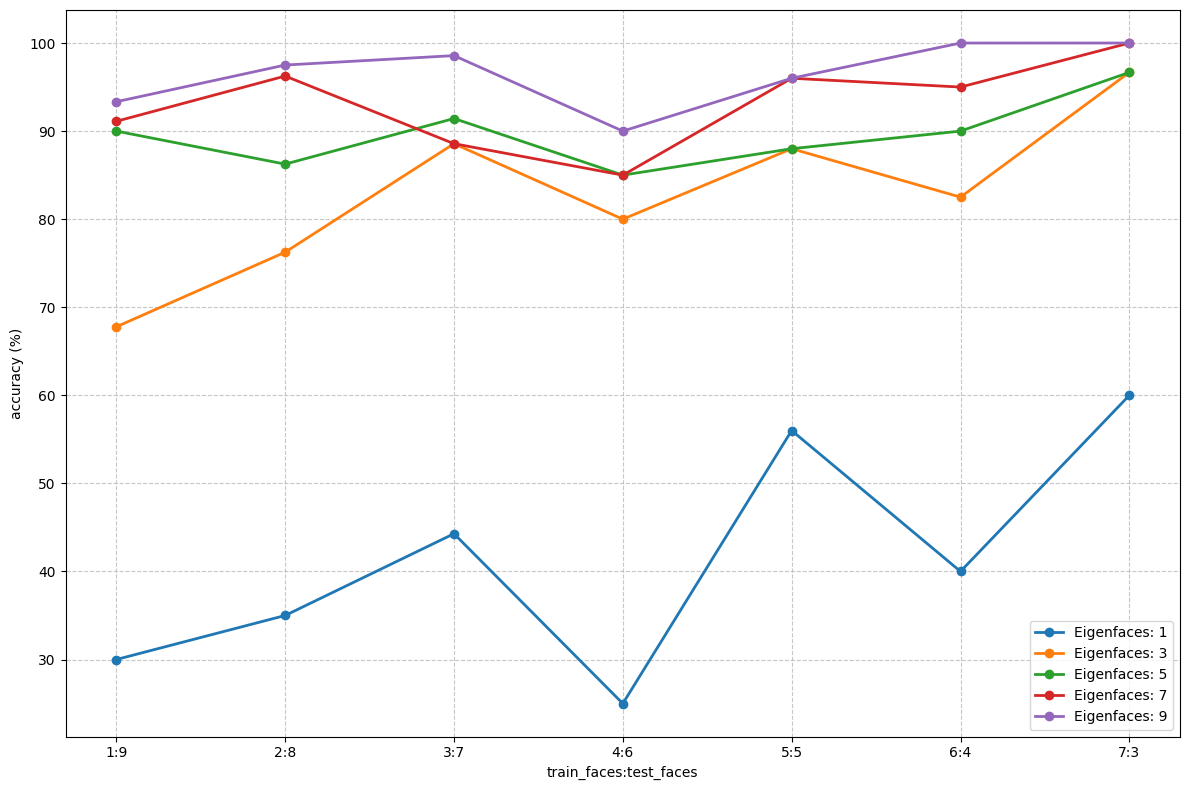

In [14]:
data_dir = "image_dataset"
results_dir = "results"

faces, labels, filenames = load_dataset(data_dir)

# 정확도 테이블 생성을 위한 비율 및 eigenface 개수 설정
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  # 1:9부터 7:3까지
eigenface_nums = [1, 3, 5, 7, 9]  # 테스트할 eigenface 개수

# 결과 테이블
results = np.zeros((len(eigenface_nums), len(ratios)))

# 각 조합에 대해 정확도 측정
for j, ratio in enumerate(ratios):
    print(f"\n학습/테스트 비율: {ratio:.1f}:{1-ratio:.1f}")
    
    train_faces, train_labels, test_faces, test_labels = split_data(faces, labels, ratio)
    mean_face = compute_mean_face(train_faces)
    eigenfaces = compute_eigenfaces(train_faces, mean_face, MAX_EIGENFACES)
    
    # 각 eigenface 개수에 대해 정확도 측정
    for i, num_components in enumerate(eigenface_nums):
        # 특정 비율과 eigenface 개수에 대한 정확도 평가
        accuracy = evaluate_accuracy(
            train_faces, train_labels, test_faces, test_labels,
            mean_face, eigenfaces, num_components
        )
        
        # 결과 저장
        results[i, j] = accuracy
        
        print(f"eigen faces {num_components} = {accuracy} % ({ratio*10:.0f} : {(1-ratio)*10:.0f})")
        
# 결과 출력
print("\n결과:")
print("\t1:9\t2:8\t3:7\t4:6\t5:5\t6:4\t7:3")
print("#eigenfaces")
for i, num_components in enumerate(eigenface_nums):
    result_line = f"{num_components}\t"
    for j in range(len(ratios)):
        result_line += f"{results[i, j]:.1f}%\t"
    print(result_line)

# 정확도 결과를 그래프로 시각화
plt.figure(figsize=(12, 8))

# 각 eigenface 개수별 선 그래프
for i, num_components in enumerate(eigenface_nums):
    plt.plot(
        [f"{int(r*10)}:{int((1-r)*10)}" for r in ratios], 
        results[i], 
        marker='o', 
        linewidth=2, 
        label=f'Eigenfaces: {num_components}'
    )

plt.xlabel('train_faces:test_faces')
plt.ylabel('accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()
